<a href="https://colab.research.google.com/github/giakomorssi/Machine_Learning/blob/main/03_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime switched to GPU
Please install GPU version of TF


In [7]:
df = pd.read_csv('/content/drive/MyDrive/University/ML/customer_segmentation_RFM.csv')

In [8]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['approved_date'] = pd.to_datetime(df['approved_date'])
df['handled_by_logistic_date'] = pd.to_datetime(df['handled_by_logistic_date'])
df['delivery_date'] = pd.to_datetime(df['delivery_date'])
df['estimated_delivery_date'] = pd.to_datetime(df['estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

# convert datetime column to numeric
df['purchase_date'] = df['purchase_date'].apply(lambda x: x.timestamp())
df['approved_date'] = df['approved_date'].apply(lambda x: x.timestamp())
df['handled_by_logistic_date'] = df['handled_by_logistic_date'].apply(lambda x: x.timestamp())
df['delivery_date'] = df['delivery_date'].apply(lambda x: x.timestamp())
df['estimated_delivery_date'] = df['estimated_delivery_date'].apply(lambda x: x.timestamp())
df['shipping_limit_date'] = df['shipping_limit_date'].apply(lambda x: x.timestamp())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13718 entries, 0 to 13717
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       13718 non-null  object 
 1   customer_id                    13718 non-null  object 
 2   order_status                   13718 non-null  int64  
 3   purchase_date                  13718 non-null  float64
 4   approved_date                  13718 non-null  float64
 5   handled_by_logistic_date       13718 non-null  float64
 6   delivery_date                  13718 non-null  float64
 7   estimated_delivery_date        13718 non-null  float64
 8   payment_type                   13718 non-null  int64  
 9   payment_installments           13718 non-null  int64  
 10  payment_value                  13718 non-null  float64
 11  customer_unique_id             13718 non-null  object 
 12  customer_city                  13718 non-null 

In [9]:
df_rfm = df[['monetary', 'frequency', 'recency']]

# Scale the Data

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()

monetary = scaler.fit_transform(df[['monetary']])
frequency = scaler.fit_transform(df[['frequency']])
recency = scaler.fit_transform(df[['recency']])

monetary = pd.DataFrame(monetary) 
frequency = pd.DataFrame(frequency)
recency = pd.DataFrame(recency)

In [11]:
X = pd.concat([monetary, frequency, recency], axis=1)
X.columns = ['monetary', 'frequency', 'recency']

# KMeans Clustering

*   Identify the proper number of clusters, and evaluate different options.
*   Describe the properties of the clusters you have identified.
*   Describe the properties of the customers belonging to each cluster

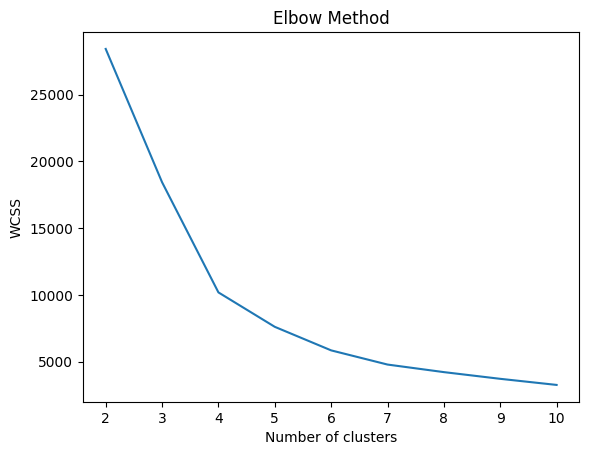

In [ ]:
# Cluster the data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import pyplot as plt
import numpy as np

# Calculate within-cluster sum of squares for different values of k
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    labels = kmeans.predict(X)

# Plot the elbow graph
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Find the optimal value for k

In [ ]:
!pip -q install kneed
from kneed import KneeLocator

# Find optimal k using elbow method
elbow = KneeLocator(range(2,11), wcss, curve='convex', direction='decreasing')
optimal_k = elbow.elbow + 1
print("Optimal k value:", optimal_k)

Optimal k value: 5


## Fit the KMeans model

In [ ]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=500, n_init=10)

X['Cluster'] = kmeans.fit_predict(X)
df_rfm['Cluster'] = X['Cluster']

print(df_rfm['Cluster'].value_counts())

1    6555
2    6544
3     372
0     208
4      39
Name: Cluster, dtype: int64


<ipython-input-10-e42dc45db7ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm['Cluster'] = X['Cluster']


## Visualization

### 3D Plot

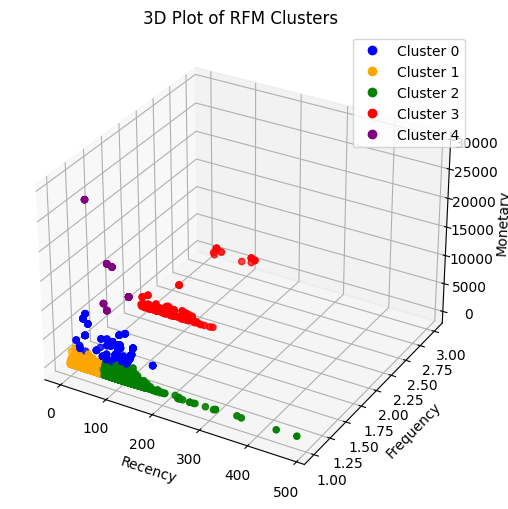

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
import matplotlib.cm as cm

colors = ['blue', 'orange', 'green', 'red', 'purple']
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# Create a ScalarMappable object for the colormap
sm = cm.ScalarMappable(cmap=cmap)
sm.set_array([])

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

# Add data to the plot
x = df_rfm['recency']
y = df_rfm['frequency']
z = df_rfm['monetary']
c = df_rfm['Cluster']
ax.scatter3D(x, y, z, c=c, cmap=cmap)

# Add labels to the plot
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Move the y-axis label to the left
ax.yaxis.set_ticks_position('both')

# Add a legend to the plot
for i in range(len(colors)):
    ax.plot([], [], 'o', color=colors[i], label=f'Cluster {i}')
    
ax.legend()

plt.title('3D Plot of RFM Clusters')
plt.show()

### 2D Plots

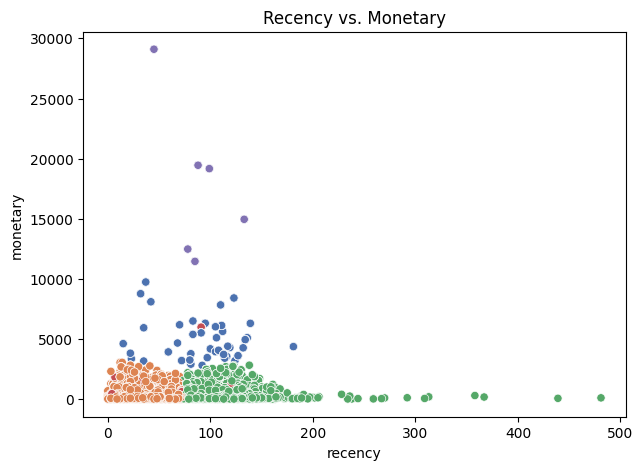

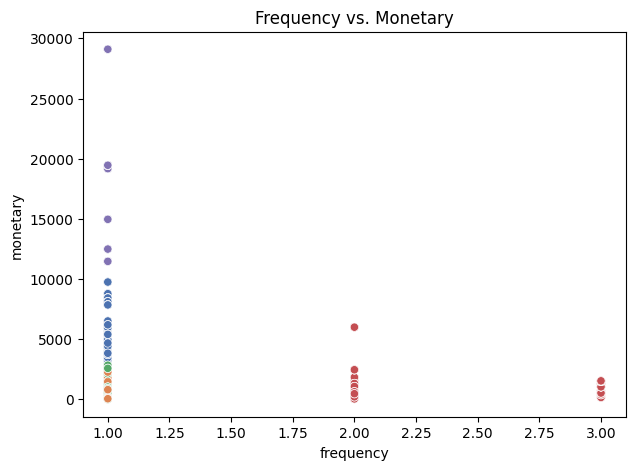

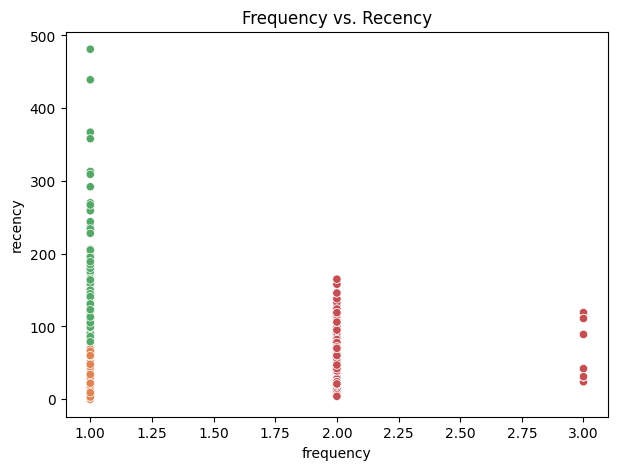

In [ ]:
import seaborn as sns

# Visualize the clusters
fig, ax = plt.subplots(figsize=(7, 5))
# Create a scatter plot of the data, with points colored by cluster label
sns.scatterplot(data=df_rfm, x=df_rfm['recency'], y=df_rfm['monetary'], hue=df_rfm['Cluster'], palette='deep', legend=None)
plt.title('Recency vs. Monetary') # Set the title of the plot
plt.show() # Show the plot

print('\n')

# Visualize the clusters
fig, ax = plt.subplots(figsize=(7, 5))
# Create a scatter plot of the data, with points colored by cluster label
sns.scatterplot(data=df_rfm, x=df_rfm['frequency'], y=df_rfm['monetary'], hue=df_rfm['Cluster'], palette='deep', legend=None)
plt.title('Frequency vs. Monetary') # Set the title of the plot
plt.show() # Show the plot

print('\n')

# Visualize the clusters
fig, ax = plt.subplots(figsize=(7, 5))
# Create a scatter plot of the data, with points colored by cluster label
sns.scatterplot(data=df_rfm, x=df_rfm['frequency'], y=df_rfm['recency'], hue=df_rfm['Cluster'], palette='deep', legend=None)
plt.title('Frequency vs. Recency') # Set the title of the plot
plt.show() # Show the plot

## Most Important Features

### Visualization

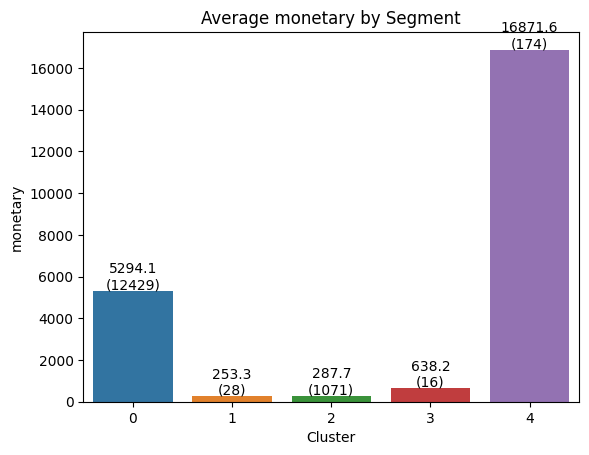

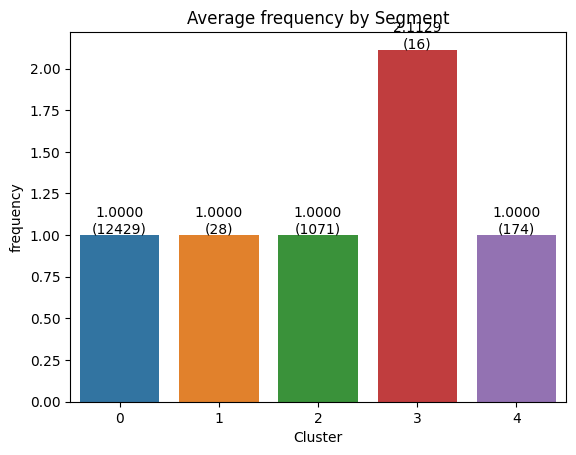

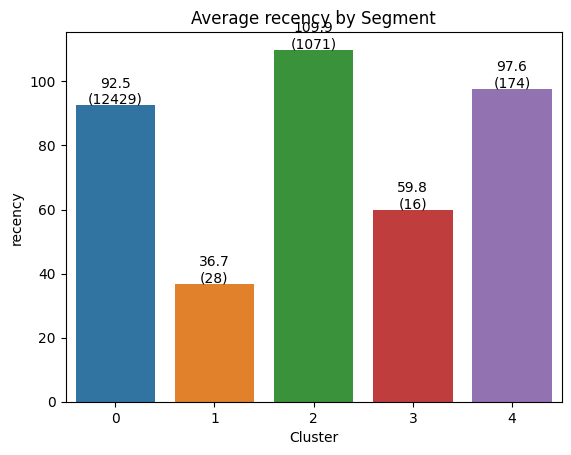

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# define the counts
counts = [12429, 28, 1071, 16, 174]

# plot for monetary
ax = sns.barplot(data=df_rfm, x='Cluster', y='monetary', errorbar=None)
plt.title('Average monetary by Segment')

# add count and value on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.1f}\n({counts[i]})",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

# plot for frequency
ax = sns.barplot(data=df_rfm, x='Cluster', y='frequency', errorbar=None)
plt.title('Average frequency by Segment')

# add count and value on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.4f}\n({counts[i]})",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

# plot for recency
ax = sns.barplot(data=df_rfm, x='Cluster', y='recency', errorbar=None)
plt.title('Average recency by Segment')

# add count and value on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.1f}\n({counts[i]})",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [ ]:
# Print average values for the 5 segments
print(df_rfm['Cluster'].value_counts())
print(df_rfm.groupby('Cluster').mean())

1    6555
2    6544
3     372
0     208
4      39
Name: Cluster, dtype: int64
             monetary  frequency     recency
Cluster                                     
0         5294.052740   1.000000   92.475962
1          253.264841   1.000000   36.676735
2          287.674267   1.000000  109.876834
3          638.174140   2.112903   59.806452
4        16871.614103   1.000000   97.564103


### Comments

* **Cluster 0: Blue**

  This cluster has the `second highest monetary value`, the `3rd highest recency value` but it has only `few observations (208)`.

* **Cluster 1: Orange** 

  This is the cluster with the `most recent purchases`, but is has the `lowest monetary value`. It is the cluster with `the most observations`.

* **Cluster 2: Green**

  This is the cluster with the `highest recency value (longer time since last buy)`, and has a `low monetary `value. It is the `2nd cluster by size`.

* **Cluster 3: Red**

  This cluster has the `2nd lowest recency` and has a `medium low monetary value`. It contains the few observations with higher frequency, it has a `frequency value of 2.11`. It has `few observations (372)`.

* **Cluster 4: Purple**

  This cluster has the `2nd highest recency`, but has the `highest monetary value`. It has `the least amount of observations (39)`.


# Hie

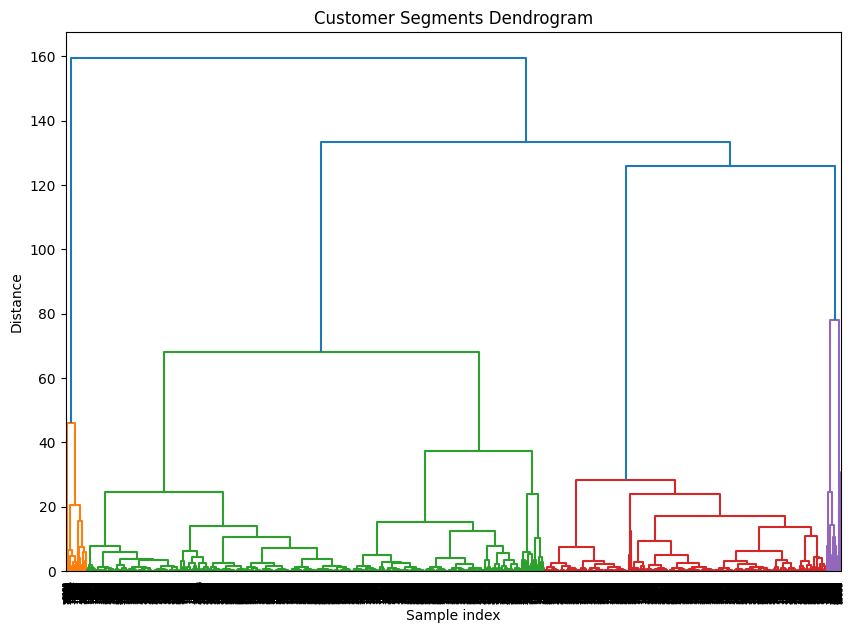

4    5004
2    4694
3    3407
1     372
5     202
6      39
Name: Cluster_h, dtype: int64


<ipython-input-12-e18470d28992>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm['Cluster_h'] = cluster_labels


In [12]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

# Perform hierarchical clustering using Ward linkage
linkage_matrix = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Customer Segments Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Determine the number of clusters based on a threshold distance value
max_dist = 70  # adjust this value to change the threshold distance
cluster_labels = fcluster(linkage_matrix, t=max_dist, criterion='distance')

# Assign cluster labels to dataframe
df_rfm['Cluster_h'] = cluster_labels

# Print cluster sizes
print(df_rfm['Cluster_h'].value_counts())

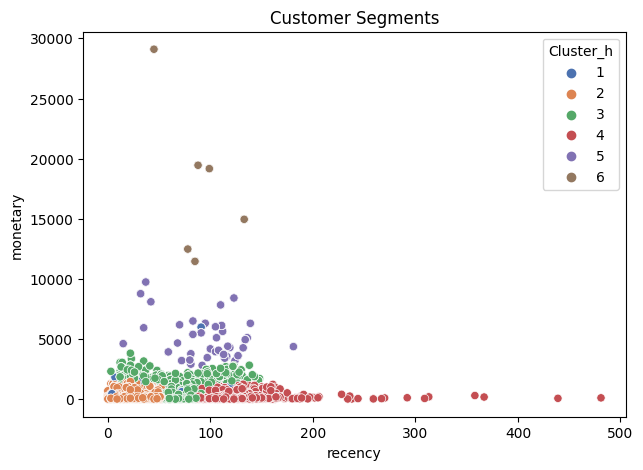

In [13]:
import seaborn as sns

clusters = df_rfm['Cluster_h']

# Visualize the clusters
fig, ax = plt.subplots(figsize=(7, 5))
# Create a scatter plot of the data, with points colored by cluster label
sns.scatterplot(data=df_rfm, x=df_rfm['recency'], y=df_rfm['monetary'], hue=df_rfm['Cluster_h'], palette='deep', legend=True)
plt.title('Customer Segments') # Set the title of the plot
plt.show() # Show the plot

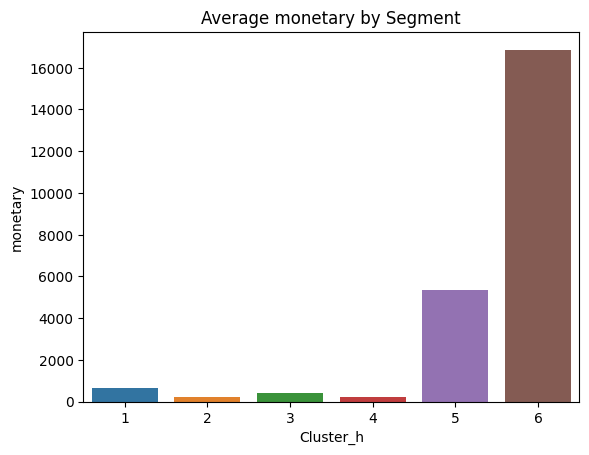

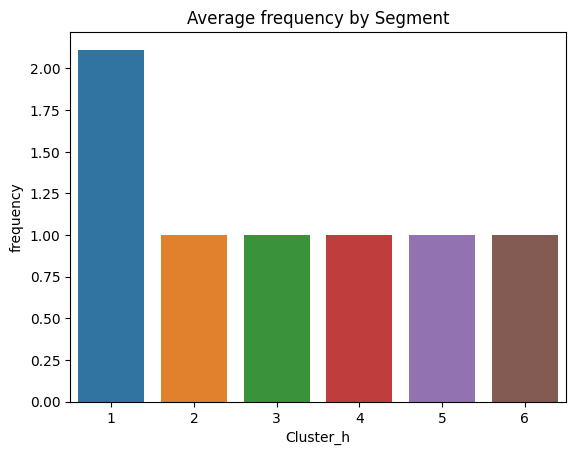

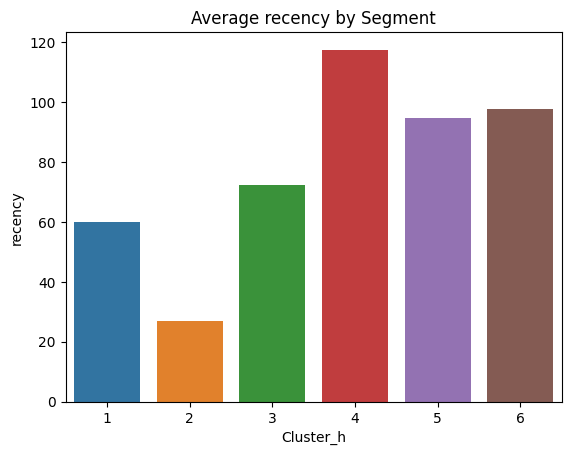

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# define the counts
counts = df_rfm['Cluster_h'].value_counts()

# plot for monetary
ax = sns.barplot(data=df_rfm, x='Cluster_h', y='monetary', errorbar=None)
plt.title('Average monetary by Segment')
plt.show()

# plot for frequency
ax = sns.barplot(data=df_rfm, x='Cluster_h', y='frequency', errorbar=None)
plt.title('Average frequency by Segment')
plt.show()

# plot for recency
ax = sns.barplot(data=df_rfm, x='Cluster_h', y='recency', errorbar=None)
plt.title('Average recency by Segment')
plt.show()


* **Cluster 1:**

  This cluster has the `second lowest recency value`, a `low monetary value` and has the `highest frequency, meaning that contains the few observations with higher frequency`. It has only `few observations (372)`.

* **Cluster 2:**

  This is the cluster with the `lower recency value`, and has a `low monetary `value. It is the cluster with the `highest number of observations(8101)`.

* **Cluster 3:**

  This cluster has the `highest recency (longer time since last purchase)`, it has the `lowest monetary value`. It has the `5004 observations`.

* **Cluster 4:**

  This cluster has a `medium-high recency`, with a `high monetary value`. It has `few observations (202)`.

* **Cluster 5:**

  This cluster has the `second highest recency`, with the `highest monetary value`. It has `few observations (39)`.